In [29]:
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import json
import os

In [30]:
# !put seed here, because I want nn.Sequential and others like train_loader and sample_generator to
# produce the same init/sample at each run, so that I can find the problem and solve it
# torch.manual_seed(20010302)
device = torch.device("cpu")
# print(device)

In [31]:
input_size = 150
output_size = 1
eps = torch.finfo(torch.float32).eps

# Create the MLP model using nn.Sequential
MLP = nn.Sequential(
    nn.Linear(input_size, 1),
    # nn.ReLU(),
    # nn.Linear(100, 1)
).to(device)

# A specific loss function for a concrete problem
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
    
    def forward(self, y_pred, y_label):
        y_pred = torch.max(y_pred, torch.ones_like(y_pred)) ** 2
        y_label = torch.max(y_label, torch.ones_like(y_label)) ** 2
        loss = torch.mean(y_label/y_pred + y_pred/y_label)
        # loss += torch.sum(torch.abs(y_pred-y_label))/len(y_label)
        return loss

In [32]:
# Define training model
def train(model, criterion, optimizer, train_loader, number_epochs):
    # print(list(MLP.parameters()))
    loss_list = []

    for epoch in range(number_epochs):
        loss_run = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # backward + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy record
            loss_run += loss.item()

        loss_run /= len(train_loader)
        loss_list.append(loss_run)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{number_epochs}], Loss: {loss_run:.4f}')

    # draw the curves
    plt.semilogy(loss_list)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

In [33]:
# make train_loader & test_loader 
with open('data.json', 'r') as f:
    data_raw = json.load(f)

x_temp = [[int(i) for i in k.split()] for k in data_raw.keys()]
# x_temp = [i + [sum(i), sum(j * k for j, k in zip(i, range(len(i)))) / 2, sum(i) ** 2, sum(i) * sum(j * k for j, k in zip(i, range(len(i)))) / 2, sum(i) ** 3] for i in x_temp]
y_temp = [[i[3]] for i in data_raw.values()]
# x_raw = torch.tensor([x_temp[i] for i in range(len(x_temp)) if y_temp[i][0] != 0], dtype=torch.float)
# y_raw = torch.tensor([y_temp[i] for i in range(len(y_temp)) if y_temp[i][0] != 0], dtype=torch.float)
dataset = data.TensorDataset(torch.tensor(x_temp, dtype=torch.float), torch.tensor(y_temp, dtype=torch.float))
train_dataset, test_dataset = data.random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])
train_loader = data.DataLoader(train_dataset, batch_size=int(len(train_dataset)/100), shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True)

Epoch [100/10000], Loss: 278.3312
Epoch [200/10000], Loss: 162.6526
Epoch [300/10000], Loss: 76.4103
Epoch [400/10000], Loss: 38.7793
Epoch [500/10000], Loss: 46.7435
Epoch [600/10000], Loss: 90.4277
Epoch [700/10000], Loss: 39.6639
Epoch [800/10000], Loss: 32.5748
Epoch [900/10000], Loss: 32.0683
Epoch [1000/10000], Loss: 46.9464
Epoch [1100/10000], Loss: 83.2141
Epoch [1200/10000], Loss: 67.5872
Epoch [1300/10000], Loss: 66.0056
Epoch [1400/10000], Loss: 57.3535
Epoch [1500/10000], Loss: 142.4069
Epoch [1600/10000], Loss: 42.6894
Epoch [1700/10000], Loss: 47.0263
Epoch [1800/10000], Loss: 307.4044
Epoch [1900/10000], Loss: 33.4300
Epoch [2000/10000], Loss: 54.7675
Epoch [2100/10000], Loss: 38.6910
Epoch [2200/10000], Loss: 23.0251
Epoch [2300/10000], Loss: 77.0795
Epoch [2400/10000], Loss: 33.3365
Epoch [2500/10000], Loss: 114.6179
Epoch [2600/10000], Loss: 29.6825
Epoch [2700/10000], Loss: 28.9739
Epoch [2800/10000], Loss: 55.6310
Epoch [2900/10000], Loss: 53.5559
Epoch [3000/10000]

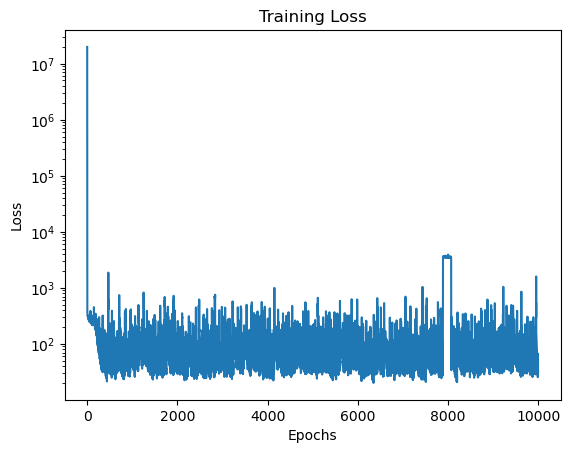

In [34]:
# train the model
learning_rate = 1e-5
# for Adam, it needs 1500, and after 1500 it will be overfit and loss will increase. the learning rate should be 1 or more
# but for SGD, it will use tens of epochs. learning rate should be 0.00001 or always get inf loss
num_epochs = 10000
# criterion = nn.MSELoss().to(device)
# criterion = nn.L1Loss().to(device)
criterion = CustomLoss().to(device)

# the weighe_decay here is important, and if loss line is strange, try to modify the lr and weight_decay.
optimizer = optim.Adam(MLP.parameters(), lr=1, betas=(0.9, 0.999))
# optimizer = optim.SGD(MLP.parameters(), learning_rate)

# print(next(MLP.parameters()).device)

train(MLP, criterion, optimizer, train_loader, num_epochs)

In [35]:
os.system('truncate -s 0 predicts.output')
# output_size = 4
q_errors = [(0,0)]*output_size
for inputs, labels in test_loader:
    outputs = MLP(inputs)
    # loss = criterion(outputs, labels)
    outputs = [max(1, round(float(i))) for i in outputs[0]]
    q_error = [float(max(outputs[i]/labels[0][i], labels[0][i]/outputs[i])) for i in range(len(outputs))]
    q_error = [0 if math.isnan(e) else round(e, 2) for e in q_error]
    with open('predicts.output', 'a') as outfile:
        outfile.write(str(q_error)+'\t\t\t'+str(float(labels))+'\t\t\t'+str(outputs)+'\n')
    q_errors = [(round(q_errors[i][0]+q_error[i],  2), q_errors[i][1]+1) if math.isinf(q_error[i])==False else q_errors[i] for i in range(output_size)]
print(q_errors)
print([round(t[0]/t[1], 2) for t in q_errors])
# print(list(MLP.parameters()))

[(20230.36, 5830)]
[3.47]
